# Part 2 Neural Network

In [30]:
import mlrose_hiive
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import learning_curve, ShuffleSplit
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv("./data/bodyPerformance.csv")

df["gender"] = (df["gender"] != "M").astype(int)

scaler = MinMaxScaler()
encoder = OneHotEncoder()

x = df.iloc[:,:-1]
y = df.iloc[:,-1]

# test train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_scaled = scaler.fit_transform(x)
y_labeled = encoder.fit_transform(y.values.reshape(-1,1)).todense()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train_labeled = encoder.fit_transform(y_train.values.reshape(-1,1)).todense()
y_test_labeled = encoder.fit_transform(y_test.values.reshape(-1,1)).todense()

### Gridsearch for NN with RHC

In [3]:
grid = {
    "learning_rate_init": [1, 0.1, 0.01],
    "max_iters": [1000, 5000],
    "activation": [mlrose_hiive.neural.activation.tanh],
    "is_classifier": [True]   
}

nn_rhc_gs = mlrose_hiive.NNGSRunner(x_train=x_train_scaled,
                     y_train=y_train_labeled,
                     x_test=x_test_scaled,
                     y_test=y_test_labeled,
                     experiment_name='NN GS RHC',
                     algorithm=mlrose_hiive.algorithms.rhc.random_hill_climb,
                     grid_search_parameters=grid,
                     iteration_list=[5000, 10000],
                     hidden_layer_sizes=[[100, 50, 25]],
                     bias=True,
                     early_stopping=False,
                     clip_max=1e+10,
                     max_attempts=500,
                     generate_curves=True,
                     seed=0,
                     n_jobs=-1)


statistics, curves, cv_result, best_estimate = nn_rhc_gs.run()
# nn_rhc.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [4]:
# best estimate for rhc grid search
best_estimate.best_params_


{'activation': <function mlrose_hiive.neural.activation.tanh.tanh(x, deriv=False)>,
 'hidden_layer_sizes': [100, 50, 25],
 'is_classifier': True,
 'learning_rate_init': 1,
 'max_iters': 10000}

In [15]:
# learning curve adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        scoring="f1_weighted",
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### NN with RHC

In [28]:
nn_rhc = mlrose_hiive.NeuralNetwork(hidden_nodes=[100, 50, 25], 
                                    activation="tanh", 
                                    algorithm="random_hill_climb",
                                    max_iters=5000,
                                    bias=True,
                                    is_classifier=True,
                                    learning_rate=0.1,
                                    early_stopping=True,
                                    clip_max=1e+10,
                                    max_attempts=500,
                                    random_state=0)

nn_rhc.fit(x_train_scaled, y_train_labeled)

NeuralNetwork(activation='tanh', early_stopping=True,
              hidden_nodes=[100, 50, 25], max_attempts=500, max_iters=5000,
              random_state=0)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

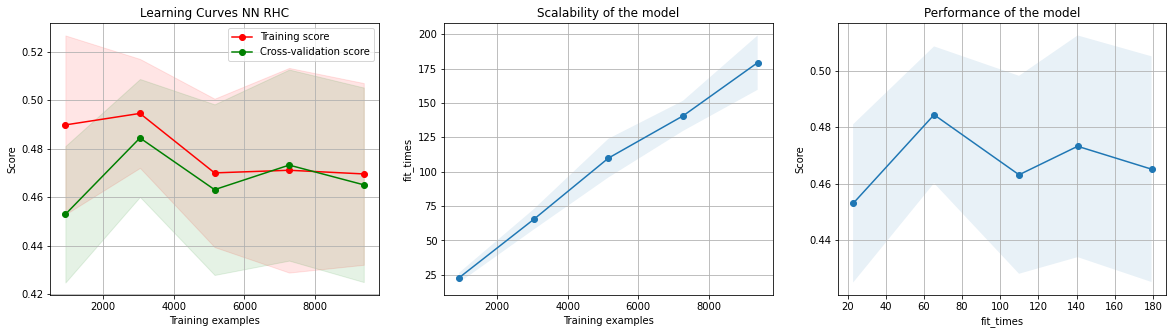

In [32]:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

plot_learning_curve(nn_rhc, 
                    "Learning Curves NN RHC", 
                    x_scaled, 
                    y_labeled,  
                    cv=cv, 
                    n_jobs=-1)

In [37]:
nn_rhc_train_pred = nn_rhc.predict(x_train_scaled)
print("NN RHC Train f1 score", f1_score(y_train_labeled, nn_rhc_train_pred, average="weighted"))
print("NN RHC Train accuracy score", accuracy_score(y_train_labeled, nn_rhc_train_pred))

nn_rhc_test_pred = nn_rhc.predict(x_test_scaled)
print("NN RHC Test f1 score", f1_score(y_test_labeled, nn_rhc_test_pred, average="weighted"))
print("NN RHC Test accuracy score", accuracy_score(y_test_labeled, nn_rhc_test_pred))

NN RHC Train f1 score 0.508259008844773
NN RHC Train accuracy score 0.5115733333333333
NN RHC Test f1 score 0.4713030707260179
NN RHC Test accuracy score 0.47859631657541063


### Gridsearch for NN with GD

In [40]:
grid = {
    "learning_rate_init": [1, 0.1],
    "max_iters": [1000, 5000],
    "clip_max": [1e+10, 1000],
    "activation": [mlrose_hiive.neural.activation.tanh],
    "is_classifier": [True]   
}

nn_rhc_gs = mlrose_hiive.NNGSRunner(x_train=x_train_scaled,
                     y_train=y_train_labeled,
                     x_test=x_test_scaled,
                     y_test=y_test_labeled,
                     experiment_name='NN GS GD',
                     algorithm=mlrose_hiive.algorithms.gd.gradient_descent,
                     grid_search_parameters=grid,
                     iteration_list=[5000, 10000],
                     hidden_layer_sizes=[[100, 50, 25]],
                     bias=True,
                     early_stopping=False,
                     clip_max=1e+10,
                     max_attempts=500,
                     generate_curves=True,
                     seed=0,
                     n_jobs=-1)


statistics, curves, cv_result, best_estimate = nn_rhc_gs.run()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
best_est

### NN with GD

In [ ]:
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes=[100, 50, 25], 
                                    activation="tanh", 
                                    algorithm="gradient_descent",
                                    max_iters=5000,
                                    bias=True,
                                    is_classifier=True,
                                    learning_rate=0.1,
                                    early_stopping=True,
                                    clip_max=1e+10,
                                    max_attempts=500,
                                    random_state=0)

nn_gd.fit(x_train_scaled, y_train_labeled)

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

plot_learning_curve(nn_gd, 
                    "Learning Curves NN GD", 
                    x_scaled, 
                    y_labeled,  
                    cv=cv, 
                    n_jobs=-1)

In [ ]:
nn_gd_train_pred = nn_rhc.predict(x_train_scaled)
print("NN RHC Train f1 score", f1_score(y_train_labeled, nn_rhc_train_pred, average="weighted"))
print("NN RHC Train accuracy score", accuracy_score(y_train_labeled, nn_rhc_train_pred))

nn_gd_test_pred = nn_rhc.predict(x_test_scaled)
print("NN RHC Test f1 score", f1_score(y_test_labeled, nn_rhc_test_pred, average="weighted"))
print("NN RHC Test accuracy score", accuracy_score(y_test_labeled, nn_rhc_test_pred))